# Ligand similarity cutoffs

This notebook explores the effect of applying ligand similarity cutoffs prior to calculating docking success rates.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

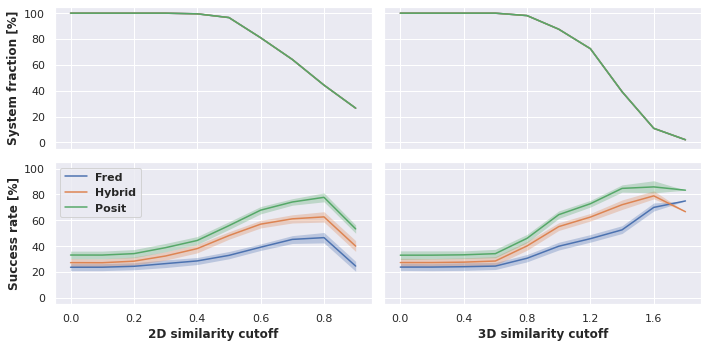

In [5]:
def plot_similarity_cutoffs(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # 2 * 2 subplots
    fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 5))
    
    # sample 2D similarity cutoffs
    sampled_success_rates = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for cutoff in [x / 10 for x in range(10)]:
            results_selection = results[results["fingerprint_similarity"] >= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i =[]
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
    # plot 2D similarity cutoffs
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["2d_similarity_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )
    sns.lineplot(
        data=sampled_success_rates, 
        x="2d_similarity_cutoff", 
        y="system_fraction", 
        hue="method", 
        ax=axes[0][0]
    )
    axes[0][0].set_ylabel("System fraction [%]", fontweight="bold")
    axes[0][0].xaxis.set_ticklabels([])
    axes[0][0].set_xlim([-0.05, 0.95])
    axes[0][0].set_ylim([-5, 105])
    axes[0][0].set_xlabel("")
    axes[0][0].get_legend().remove()

    ax = sns.lineplot(data=sampled_success_rates, x="2d_similarity_cutoff", y="success_rate", hue="method", ci=None, ax=axes[1][0])
    axes[1][0].set_xlabel("2D similarity cutoff", fontweight="bold")
    axes[1][0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[1][0].set_ylim([-5, 105])
    axes[1][0].set_xlim([-0.05, 0.95])
    axes[1][0].legend(prop=dict(weight="bold"), fancybox=True)
    # plot ci
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["2d_similarity_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["2d_similarity_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["2d_similarity_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    
    # sample 3D similarity cutoffs
    sampled_success_rates2 = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for cutoff in [(x / 10) * 2 for x in range(10)]:
            results_selection = results[results["shape_similarity"] >= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates2.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
    # plot 3D similarity cutoffs
    sampled_success_rates2 = pd.DataFrame(
        sampled_success_rates2, columns=["3d_similarity_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )    
    sns.lineplot(
        data=sampled_success_rates2, 
        x="3d_similarity_cutoff", 
        y="system_fraction", 
        hue="method", 
        ax=axes[0][1]
    )
    axes[0][1].set_xlabel("")
    axes[0][1].xaxis.set_ticklabels([])
    axes[0][1].set_xlim([-0.1, 1.9])
    axes[0][1].set_xticks([0, 0.4, 0.8, 1.2, 1.6])
    axes[0][1].get_legend().remove()
    
    ax = sns.lineplot(data=sampled_success_rates2, x="3d_similarity_cutoff", y="success_rate", hue="method", ci=None, ax=axes[1][1])
    axes[1][1].set_xlabel("3D similarity cutoff", fontweight="bold")
    axes[1][1].set_xlim([-0.1, 1.9])
    axes[1][1].set_xticks([0, 0.4, 0.8, 1.2, 1.6])
    axes[1][1].get_legend().remove()
    # plot ci
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Fred"]["3d_similarity_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Hybrid"]["3d_similarity_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["3d_similarity_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    plt.tight_layout()
    plt.savefig(directory / "similarity_cutoffs.png", dpi=300)
    
    return sampled_success_rates, sampled_success_rates2

success_rates_2d_similarity, success_rates_3d_similarity = plot_similarity_cutoffs(
    fred_results, hybrid_results, posit_results
)

In [6]:
success_rates_2d_similarity

,2d_similarity_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,0.0,Fred,23.675382,21.052632,26.485569,100.000000
1,0.1,Fred,23.707640,21.052632,26.485569,100.000000
2,0.2,Fred,24.408659,21.731749,27.164686,100.000000
3,0.3,Fred,26.494737,23.429542,29.371817,100.000000
4,0.4,Fred,28.574403,25.767918,31.228669,99.490662
5,0.5,Fred,32.866784,30.228471,35.852373,96.604414
6,0.6,Fred,39.193082,36.687631,41.719078,80.984720
7,0.7,Fred,45.231481,42.063492,48.148148,64.176570
8,0.8,Fred,46.602299,42.528736,50.574713,44.312394
9,0.9,Fred,24.582051,20.512821,28.205128,26.485569


In [7]:
success_rates_3d_similarity

,3d_similarity_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,0.0,Fred,23.792020,21.222411,26.655348,100.000000
1,0.2,Fred,23.803905,21.052632,26.485569,100.000000
2,0.4,Fred,24.091681,21.222411,27.164686,100.000000
3,0.6,Fred,24.568081,21.901528,27.334465,100.000000
4,0.8,Fred,30.641869,27.854671,33.564014,98.132428
5,1.0,Fred,39.933915,37.015504,43.023256,87.606112
6,1.2,Fred,45.791335,43.091335,48.946136,72.495756
7,1.4,Fred,52.629437,49.783550,55.844156,39.219015
8,1.6,Fred,70.003125,67.187500,73.437500,10.865874
9,1.8,Fred,75.000000,75.000000,75.000000,2.037351
